# AfDesign - peptide binder design
For a given protein target and protein binder length, generate/hallucinate a protein binder sequence AlphaFold thinks will bind to the target structure. To do this, we maximize number of contacts at the interface and maximize pLDDT of the binder.

**WARNING**
1.   This notebook is in active development and was designed for demonstration purposes only.
2.   Using AfDesign as the only "loss" function for design might be a bad idea, you may find adversarial sequences (aka. sequences that trick AlphaFold).

In [1]:
import os, re, sys, string, argparse, jax, subprocess, tempfile, Bio, shutil, mrcfile
sys.path.insert(0, '/work/lpdi/users/shxiao/ColabDesign/')

import numpy as np
import pandas as pd
import jax.numpy as jnp

from scipy.special import softmax
from scipy.spatial import cKDTree 
from scipy.spatial.distance import cdist, hamming

from colabdesign import mk_afdesign_model, clear_mem
from colabdesign.mpnn import mk_mpnn_model
from colabdesign.shared.prep import prep_pos
from colabdesign.shared.utils import copy_dict
from colabdesign.af.prep import prep_pdb
from colabdesign.af.alphafold.common import protein, residue_constants
from colabdesign.shared.protein import renum_pdb_str

from Bio.PDB import *
from Bio.PDB.StructureBuilder import StructureBuilder
from Bio.PDB.Selection import unfold_entities
from Bio import SeqUtils
from Bio.Align import substitution_matrices

from abnumber import Chain

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

aligner = Bio.Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

AA3to1_covert = SeqUtils.IUPACData.protein_letters_3to1
AA3to1_covert = {k.upper(): v for k,v in AA3to1_covert.items()}
af_alphabet = 'ARNDCQEGHILKMFPSTWYVX'
PDB_CHAIN_IDS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'

# Kyte & Doolittle index of hydrophobicity
# J. Mol. Biol. 157:105-132(1982).
# "KyteDoolittle"
kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
      "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
      "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
      "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2}

py3Dmol not installed


In [2]:
def diffuse(
    input_pdb_path,
    output_pdb_path_prefix,
    CDR3len,
    seed: int = 0,
    num_designs: int = 10,
    executable: str = '/work/lpdi/users/shxiao/RFdiffusion/run_inference.py',
):
    "Create loop variability using RFdiffusion"
    
    if not os.path.isfile(executable):
        print("RFdiffusion executable not existent!")
        sys.exit(1)
    
    cmd = [
        "python",
        executable,
        f"inference.seed={seed}",
        f"inference.num_designs={num_designs}",
        f"inference.input_pdb={input_pdb_path}",           
        f"inference.output_prefix={output_pdb_path_prefix}",
        f"contigmap.contigs=[H27-124/{CDR3len}/H142-155/0 L25-131]"
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    for i in range(num_designs):
        cmd = [
            "/work/lpdi/users/shxiao/USalign", 
            f"{output_pdb_path_prefix}_{i}.pdb", 
            f"{input_pdb_path}", 
            '-mm', '1', '-ter', '0',
            '-o', f"{output_pdb_path_prefix}_{i}_aln",
        ]
        
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        
    print(f'Diffusion done for {num_designs} designs.')

In [3]:
def rank_array(input_array):
    # numpy.argsort returns the indices that would sort an array.
    # We convert it to a python list before returning
    return list(np.argsort(input_array))
    
def rank_and_write_pdb(af_model, name, write_all=False, renum_pdb=True):
    ranking = rank_array(af_model.aux["all"]["loss"])
    if write_all != True:
        ranking = [ranking[0]]

    aux = af_model._tmp["best"]["aux"]
    aux = aux["all"]

    p = {k: aux[k] for k in ["aatype", "residue_index", "atom_positions", "atom_mask"]}
    unique_chain_ids = np.unique(af_model._pdb["idx"]["chain"])
    chain_id_mapping = {cid: n for n, cid in enumerate(list(PDB_CHAIN_IDS))}
    chain_index = np.array([chain_id_mapping[cid] for cid in af_model._pdb["idx"]["chain"]])
    p["chain_index"] = np.r_[[chain_index], [chain_index]]
    p["b_factors"] = 100 * p["atom_mask"] * aux["plddt"][..., None]

    def to_pdb_str(x, n=None):
        p_str = protein.to_pdb(protein.Protein(**x))
        p_str = "\n".join(p_str.splitlines()[1:-2])
        if renum_pdb:
            p_str = renum_pdb_str(p_str, af_model._lengths)
        if n is not None:
            p_str = f"MODEL{n:8}\n{p_str}\nENDMDL\n"
        return p_str

    for n in ranking:
        p_str = ""
        p_str += to_pdb_str(jax.tree_map(lambda x: x[n], p), None)
        p_str += "END\n"

        with open(name, "w") as f:
            f.write(p_str)

def rank_array_predict(input_array):
    # numpy.argsort returns the indices that would sort an array.
    # We convert it to a python list before returning
    return list(np.argsort(input_array))[::-1]
    
def rank_and_write_pdb_predict(af_model, name, write_all=False, renum_pdb=True):
    ranking = rank_array_predict(np.mean(af_model.aux["all"]["plddt"], -1))
    if write_all != True:
        ranking = [ranking[0]]
    
    aux = af_model.aux
    aux = aux["all"]

    p = {k: aux[k] for k in ["aatype", "residue_index", "atom_positions", "atom_mask"]}
    unique_chain_ids = np.unique(af_model._pdb["idx"]["chain"])
    chain_id_mapping = {cid: n for n, cid in enumerate(list(PDB_CHAIN_IDS))}
    chain_index = np.array([chain_id_mapping[cid] for cid in af_model._pdb["idx"]["chain"]])
    p["chain_index"] = np.r_[[chain_index], [chain_index]]
    p["b_factors"] = 100 * p["atom_mask"] * aux["plddt"][..., None]

    def to_pdb_str(x, n=None):
        p_str = protein.to_pdb(protein.Protein(**x))
        p_str = "\n".join(p_str.splitlines()[1:-2])
        if renum_pdb:
            p_str = renum_pdb_str(p_str, af_model._lengths)
        if n is not None:
           p_str = f"MODEL{n:8}\n{p_str}\nENDMDL\n"
        return p_str

    for n in ranking:
        p_str = ""
        p_str += to_pdb_str(jax.tree_map(lambda x: x[n], p), None)
        p_str += "END\n"

        with open(name, "w") as f:
            f.write(p_str)

In [4]:
def create_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=str)
    parser.add_argument('--num_diffusion_designs', type=int, default=20)
    # parser.add_argument('--em_map_path', type=str)
    # parser.add_argument('--density_cutoff', type=float, default=0.010)
    parser.add_argument('--num_afdesign_designs', type=int, default=10)
    parser.add_argument('--num_mpnn_designs', type=int, default=10)
    parser.add_argument('--learning_rate', type=float, default=2e-2)
    parser.add_argument('--target_pdb', type=str)
    parser.add_argument('--target_chain', type=str)
    parser.add_argument('--target_hotspot', type=str)
    parser.add_argument('--target_flexible', action='store_true', help='Whether to allow target to be flexible')
    parser.add_argument('--binder_pdb', type=str, default="1ttg")
    parser.add_argument('--binder_chain', type=str, default='A')
    parser.add_argument('--fix_pos', type=str, default=None)
    parser.add_argument('--rm_aa', type=str, default='C')
    parser.add_argument('--use_multimer', action='store_true', help='Whether to use AFmultimer')
    parser.add_argument('--num_recycles', type=int, default=1, help='Number of recycles')
    parser.add_argument('--num_models', type=str, default=2, help='Number of trained models to use during optimization; "all" for all models')
    parser.add_argument('--use_binder_template', action='store_true', help='Whether to use binder template')
    parser.add_argument('--rm_template_ic', action='store_true', help='Whether to remove template interchain information')
    parser.add_argument('--use_mpnn_loss', action='store_true', help='Whether to use MPNN loss')
    parser.add_argument('--mpnn_weights', type=str, default='abmpnn, soluble, original')
    parser.add_argument('--mpnn_model_name', type=str, default='abmpnn; v_48_002; v_48_010; v_48_020; v_48_030')
    parser.add_argument('--rfdiffusion_executable',type=str, help='Path to RFdiffusion\'s executable.', default='/work/lpdi/users/shxiao/RFdiffusion/run_inference.py')

    return parser

In [5]:
def process_ab(
    input_path: str, 
    output_path: str,
    chains: str,
    mpnn_fixed_regions = None,
    mpnn_weights: str = 'abmpnn',
    mpnn_model_name: str = 'abmpnn',
    seed: int = 42
):
    AA3to1_covert = SeqUtils.IUPACData.protein_letters_3to1
    AA3to1_covert = {k.upper(): v for k,v in AA3to1_covert.items()}

    parser = PDBParser(QUIET=True)
    ab_struct = parser.get_structure("ab", input_path)

    mpnn_model = mk_mpnn_model(model_name=mpnn_model_name, weights=mpnn_weights, seed=seed)
    mpnn_model.prep_inputs(pdb_filename=input_path, chain=chains, fix_pos=mpnn_fixed_regions, inverse=True)
    O = mpnn_model.sample(num=1, batch=1, temperature=0.1, rescore=False)
    seqs = O['seq'][0]
    
    ab_seq = []
    for chain, seq in zip(chains.split(','), seqs.split('/')):        
        abnumber_chain = Chain(seq, scheme='chothia')
        fab = re.search(abnumber_chain.seq, seq)
        mask = np.ones(len(seq), dtype=bool)
        mask[np.arange(*fab.span())] = 0.0
        
        for c in ab_struct[0]:
            if c.get_id() == chain:
                all_res_id = [r.get_id()[1] for r in c.get_residues()]
                for i in np.where(mask)[0]:
                    c.detach_child((' ', all_res_id[i], ' '))
        
        ab_seq.append(abnumber_chain.seq)
    
    io = PDBIO()
    io.set_structure(ab_struct)
    io.save(output_path)
    
    return '/'.join(ab_seq)
    
def combine_pdbs(
    target_pdb: str, target_chain: str, 
    binder_pdb: str, binder_chain: str, 
    binder_pdb_processed: str,
    output_pdb_path: str, 
    seed: int = 42,
    mpnn_fixed_regions = None,
    mpnn_weights: str = 'abmpnn',
    mpnn_model_name: str = 'abmpnn',
    ):
    
    ''' Combine the target and binder PDB files into a single PDB file '''
    
    output = {}
    new_chain_name_list = list(string.ascii_uppercase)

    ab_seq = process_ab(binder_pdb, binder_pdb_processed, binder_chain, mpnn_fixed_regions=mpnn_fixed_regions, mpnn_weights=mpnn_weights, mpnn_model_name=mpnn_model_name, seed=seed)
    
    # Read the PDB file
    parser = PDBParser(QUIET=True)
    target_struct = parser.get_structure("target", target_pdb)
    binder_struct = parser.get_structure("binder", binder_pdb_processed)
    target_chains = [chain for chain in target_struct.get_chains() if chain.id in target_chain.split(',')]
    binder_chains = [chain for chain in binder_struct.get_chains() if chain.id in binder_chain.split(',')]
    target_chains_id = [chain.id for chain in target_chains]
    binder_chains_id = [chain.id for chain in binder_chains]
    
    # NOTE: Renumber the binder chain ID to avoid chain name reoccurancebiasing_mask
    if np.in1d(target_chains_id, binder_chains_id).any():
        binder_chains_id = []
        for chain in target_chains_id:
            new_chain_name_list.remove(chain)
        for idx, chain in enumerate(binder_chains): 
            new_chain_id = new_chain_name_list[idx]
            chain.id = new_chain_id
            binder_chains_id.append(new_chain_id)
            
    sb = StructureBuilder()
    sb.init_structure("combined")
    sb.init_model(0)
    combined_struct = sb.get_structure()
    for idx, chain in enumerate(target_chains+binder_chains):
        combined_struct[0].add(chain)

    '''Combining the chains into a single PDB file'''    
    class NonHetSelect(Select):        
        '''Selects only non-hetero atoms'''
        def accept_residue(self, residue):            
            return 1 if residue.id[0] == " " else 0

    io = PDBIO()
    io.set_structure(combined_struct)
    io.save(output_pdb_path)
    io.save(output_pdb_path, NonHetSelect())

    output.update(
        {
            "target_chain": ','.join(target_chains_id),
            "binder_chain": ','.join(binder_chains_id), 
            "binder_starting_seq": ab_seq,
        }
    )
    
    return output

def add_mpnn_loss(self, model_name='abmpnn', weights='abmpnn', mpnn=0.2, mpnn_seq=0.1, seed=42):
    '''
    add mpnn loss
    weights: ['original', 'soluble', 'abmpnn']
    mpnn = maximize confidence of proteinmpnn
    mpnn_seq = push designed sequence to match proteinmpnn logits
    '''
    self._mpnn = mk_mpnn_model(model_name=model_name, weights=weights, seed=seed)
    def loss_fn(inputs, outputs, aux, key):
        # get structure
        atom_idx = tuple(residue_constants.atom_order[k] for k in ["N","CA","C","O"])
        I = {"S":           inputs["aatype"],
                "residue_idx": inputs["residue_index"],
                "chain_idx":   inputs["asym_id"],
                "X":           outputs["structure_module"]["final_atom_positions"][:,atom_idx],
                "mask":        outputs["structure_module"]["final_atom_mask"][:,1],
                "lengths":     self._lengths,
                "key":         key}

        if "offset" in inputs:
            I["offset"] = inputs["offset"]

        # set autoregressive mask
        L = sum(self._lengths)
        if self.protocol == "binder":
            I["ar_mask"] = 1 - np.eye(L)
            I["ar_mask"][-self._len:,-self._len:] = 0
        else:
            I["ar_mask"] = np.zeros((L,L))

        # get logits
        logits = self._mpnn._score(**I)["logits"][:,:20]
        if self.protocol == "binder":
            logits = logits[-self._len:]
        else:
            logits = logits[:self._len]
        aux["mpnn_logits"] = logits

        # compute loss
        log_q = jax.nn.log_softmax(logits)
        p = inputs["seq"]["hard"]
        q = jax.nn.softmax(logits)
        losses = {}
        losses["mpnn"] = -log_q.max(-1).mean()
        losses["mpnn_seq"] = -(p * jax.lax.stop_gradient(log_q)).sum(-1).mean()
        return losses

    self._callbacks["model"]["loss"].append(loss_fn)
    self.opt["weights"]["mpnn"] = mpnn
    self.opt["weights"]["mpnn_seq"] = mpnn_seq

In [6]:
import re, tempfile
import Bio
from Bio.Align import substitution_matrices

aligner = Bio.Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

def parse_hhalign_output(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    start_indices, sequences = [None,None], ["",""]
    for line in lines:
        parts = line.split()
        if line.startswith('Q '):
            if start_indices[0] is None:
                start_indices[0] = int(parts[2]) - 1
            sequences[0] += parts[3]
            
        if line.startswith('T '):
            if start_indices[1] is None:
                start_indices[1] = int(parts[2]) - 1
            sequences[1] += parts[3]
    
    return sequences, start_indices

def get_template_idx(query_sequence, target_sequence, query_a3m=None, target_a3m=None, align_fn=None):

    if align_fn is None:
        align_fn = lambda a,b,**c: list(aligner.align(a[0],b[0])[0]),(0,0)

    if len(query_sequence) == len(target_sequence):
        i = np.arange(len(query_sequence))
        return i,i
    else:
        X,(i,j) = align_fn(query_sequence, target_sequence, query_a3m=query_a3m, target_a3m=target_a3m)
        print(f"Q\t{X[0]}\nT\t{X[1]}")
        idx_i, idx_j = [], []
        for q,t in zip(*X):
            if q != "-" and t != "-":
                idx_i.append(i)
                idx_j.append(j)
            if q != "-": i += 1
            if t != "-": j += 1

    return np.array(idx_i), np.array(idx_j)
      
def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
    with tempfile.NamedTemporaryFile() as tmp_query, tempfile.NamedTemporaryFile() as tmp_target, tempfile.NamedTemporaryFile() as tmp_alignment:
        if query_a3m is None:
            tmp_query.write(f">Q\n{query_sequence}\n".encode())
            tmp_query.flush()
            query_a3m = tmp_query.name
        if target_a3m is None:
            tmp_target.write(f">T\n{target_sequence}\n".encode())
            tmp_target.flush()
            target_a3m = tmp_target.name
        os.system(f"/work/lpdi/users/shxiao/hhsuite/bin/hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
        X, start_indices = parse_hhalign_output(tmp_alignment.name)
    
    return X, start_indices

In [14]:
def design(
    input_args: dict,
    design_name: str,
    output_dir: str,
    binder_starting_seq: str, # NOTE: starting sequence (used for calculating seqid) can be MPNN designed seq
    rm_aa: str,               # NOTE: to prevent given AA types in all positions
    biasing_aa: str,          # NOTE: to bias against given AA types in the selected positions
    biasing_mask,             # NOTE: selected positions for biasing against
    pssm_steps: int = 100,
    semi_greedy_steps: int = 24,
    seed: int = 0, 
    lr: float = 2e-2, 
    num_models: int = 2, 
    num_recycles: int = 1
    ):
    '''
    Design binder sequence using PSSM-semigreedy optimization
    '''    
    clear_mem()
    af_model = mk_afdesign_model(
        protocol="binder",
        use_multimer=input_args["use_multimer"],
        num_recycles=num_recycles,
        data_dir="/work/lpdi/users/shxiao/params/",
    )
    af_model.prep_inputs(**input_args, ignore_missing=False)
    
    # add_dist_loss(af_model, input_args['binder_chain'], input_args['target_chain'], input_args['map_path'], 0.1, input_args['density_cutoff'])

    if args.use_mpnn_loss: add_mpnn_loss(af_model, weights=args.mpnn_weights, model_name=args.mpnn_model_name, mpnn=0.1, mpnn_seq=0.0, seed=seed)

    # NOTE: Important step: fix binder positions
    af_model._pdb["len"] = sum(af_model._pdb["lengths"])
    af_model.opt["pos"] = af_model._pdb["pos"] = np.arange(af_model._pdb["len"])
    af_model._pos_info = {"length":np.array([af_model._pdb["len"]]), "pos":af_model._pdb["pos"]}

    sub_fix_pos = []
    sub_i = []
    pos = af_model.opt["pos"].tolist()
    residues = af_model._pdb["idx"]['residue'][np.in1d(af_model._pdb["idx"]["chain"], input_args['binder_chain'].split(','))]
    chains = af_model._pdb["idx"]['chain'][np.in1d(af_model._pdb["idx"]["chain"], input_args['binder_chain'].split(','))]

    if args.fix_pos:
        # NOTE: IMPORTANT for fixing N-term seq of Mob!!!
        for i in prep_pos(args.fix_pos, residues, chains)["pos"]:
            if i in pos:
                sub_i.append(i)
                sub_fix_pos.append(pos.index(i))
        sub_i += af_model._target_len
        af_model.opt["fix_pos"] = np.array(sub_fix_pos)
        af_model._wt_aatype_sub = af_model._pdb["batch"]["aatype"][sub_i]
    
    af_model.opt["weights"].update({"dgram_cce":0.1, "plddt":0.0, "rmsd":0.0, "con":0.0, "i_con":1.0, "i_pae":0.0})
    print("weights", af_model.opt["weights"])
    print(f'\nNow designing {design_name}...\n[Random seed {seed}]: Designing binder sequence using PSSM-semigreedy optimization...')
    af_model.restart(seq=binder_starting_seq, rm_aa=rm_aa, seed=seed, reset_opt=False)
    af_model.set_optimizer(optimizer="adam", learning_rate=lr, norm_seq_grad=True)

    # NOTE: Prevent templating the loop regions !!!
    (T,L,rm) = (af_model._lengths[0],sum(af_model._lengths),{})
    rm_opt_list = ['rm_template', 'rm_template_seq', 'rm_template_sc']
    for n in rm_opt_list:
        rm[n] = np.full(L,False)
        rm[n][-af_model._binder_len:] = biasing_mask

    af_model._inputs.update(rm)
    
    models = af_model._model_names[:num_models]
    flags = {"num_recycles":num_recycles,
            "models":models,
            "dropout":True}
    
    af_model.design_pssm_semigreedy(pssm_steps, semi_greedy_steps, **flags)
    rank_and_write_pdb(af_model, name=os.path.join(output_dir, f"{design_name}.pdb"), write_all=False, renum_pdb=False)

    return af_model

In [8]:
def mpnn_redesign(
    input_args: dict,
    result: dict,
    design_name: str,
    template_path: str, 
    output_dir: str,
    seed: int = 0, 
    num_designs: int = 8,
    sampling_temp: float = 0.2,
    rm_aa: str = 'C',               # NOTE: to prevent given AA types in all positions
    model_name: str = 'abmpnn',
    weights: str = 'abmpnn',
):      
    clear_mem()
    mpnn_model = mk_mpnn_model(model_name=model_name, weights=weights, seed=seed)        
    
    mpnn_model.prep_inputs(
        pdb_filename=template_path,
        chain=','.join([input_args['target_chain'], input_args['binder_chain']]),
        fix_pos=input_args['target_chain'],
        inverse=False,
        rm_aa=rm_aa,
        verbose=False
    )

    def find_interface(mpnn_model, binder_chain: str):
        binder_chain_id = np.in1d(mpnn_model.pdb['idx']['chain'], binder_chain.split(','))
        binder_atom_coords = mpnn_model.pdb['cb_feat']['atoms'][binder_chain_id]
        target_atom_coords = mpnn_model.pdb['cb_feat']['atoms'][~binder_chain_id]
        
        target_ckdtree = cKDTree(target_atom_coords) 
        d,r = target_ckdtree.query(binder_atom_coords)
        
        interface_masking = (d<=7.0)
    
        return interface_masking

    interface_mask = find_interface(mpnn_model, input_args['binder_chain'])
    # interface_mask[:24] = 0.0  # NOTE: Make sure the first 24 is not selected
    binder_chain_id = np.in1d(mpnn_model.pdb['idx']['chain'], input_args['binder_chain'].split(','))

    binder_bias = mpnn_model._inputs["bias"][np.where(binder_chain_id)]
    for i in np.where(~interface_mask)[0]:
        ori_aa = mpnn_model.pdb['batch']['aatype'][binder_chain_id][i]    
        binder_bias[i, ori_aa] = 1e7
    
    mpnn_model._inputs["bias"][np.where(binder_chain_id)] = binder_bias
    
    out = mpnn_model.sample(num=num_designs, temperature=sampling_temp)

    return out

In [9]:
def predict(
    input_args: dict,
    result: dict,
    design_name: str,
    template_path: str,
    input_seq: str, 
    output_dir: str,
    seed: int = 0, 
    num_models: int = 2, 
    num_recycles: int = 3,
    **kwargs
    ):
    '''
    Predicting with AF2Rank with loop being masked
    '''
    clear_mem()
    af_model = mk_afdesign_model(
        protocol="binder",
        use_multimer=True,
        num_recycles=args.num_recycles,
        data_dir="/work/lpdi/users/shxiao/params/",    
    )
    
    print(f'Now predicting {design_name} with AF2Rank...')    
    
    af_model.prep_inputs(
        pdb_filename=template_path, 
        target_chain=input_args['target_chain'],
        binder_chain=input_args['binder_chain'],
        initial_guess=True,
        rm_target=False,
        rm_target_seq=False,
        rm_target_sc=False,
        rm_binder=False,
        rm_binder_seq=True,
        rm_binder_sc=True,
        rm_template_ic=True
    )

    def find_interface(af_model, binder_chain: str):
        binder_chain_id = np.in1d(af_model._pdb['idx']['chain'], binder_chain.split(','))
        binder_atom_coords = af_model._pdb['cb_feat']['atoms'][binder_chain_id]
        target_atom_coords = af_model._pdb['cb_feat']['atoms'][~binder_chain_id]
        
        target_ckdtree = cKDTree(target_atom_coords) 
        d,r = target_ckdtree.query(binder_atom_coords)
        
        interface_masking = (d<=7.0)
    
        return interface_masking

    interface_mask = find_interface(af_model, input_args['binder_chain'])
    
    if 'biasing_mask' in kwargs:
        biasing_mask = kwargs['biasing_mask']
        all_mask = biasing_mask | interface_mask

    print(f'Masking {len(np.where(all_mask)[0])} residues on binder for prediction...')
    af_model._inputs['batch']['all_atom_mask'][-af_model._binder_len:][all_mask, :] = np.zeros_like(af_model._inputs['batch']['all_atom_mask'][-af_model._binder_len:][all_mask, :])
    
    models = af_model._model_names[:num_models]
    
    flags = {
        "num_recycles":num_recycles,
        "models":models,
        "dropout":True
    }

    af_model.predict(seq=input_seq, return_aux=False, verbose=True, seed=seed, **flags)
    rank_and_write_pdb_predict(af_model, name=os.path.join(output_dir, f"{design_name}.pdb"), write_all=False, renum_pdb=False)

    print(f'\nDone.\n')    
    
    return af_model, interface_mask

In [1]:
def partition_empem_density(self, binder_chain, target_chain, map_path: str, density_cutoff: float = 0.2):
    '''
    This function takes the antibody template and the electrion density map and returns the density points 
    that are closest to the antibody backbone
    '''
    atom_coords = self._pdb['batch']['all_atom_positions']
    binder_chain_id = np.in1d(self._pdb['idx']['chain'], binder_chain.split(','))
    target_chain_id = np.in1d(self._pdb['idx']['chain'], target_chain.split(','))

    target_atom_coords = atom_coords[target_chain_id][np.where(self._pdb['batch']['all_atom_mask'][target_chain_id])].reshape(-1, 3)

    xyz, emd = read_mrc(map_path)
    density_sele_idx = np.where(emd>=density_cutoff)
    emd_values = emd[np.where(emd>=density_cutoff)]
    dim = int(np.cbrt(xyz.shape[0]))
    map_coords = xyz.reshape(dim, dim, dim, 3)[np.where(emd>=density_cutoff)]
        
    map_cdktree = cKDTree(map_coords)
    d1, r1 = map_cdktree.query(target_atom_coords, k=100)
    
    target_sele_idx = np.unique(r1[np.where(d1<=3.0)])
    target_sele = np.zeros(len(map_coords), dtype=bool)
    target_sele[target_sele_idx] = 1.0
    binder_sele = ~target_sele
    
    return map_coords[binder_sele], map_coords[target_sele]

def read_mrc(mrcfilename):
    """
    Read a mrc file and return the xyz and density values at the given level
    if given
    """
    xyz = []
    with mrcfile.open(mrcfilename) as emd:
        nx, ny, nz = emd.header['nx'], emd.header['ny'], emd.header['nz']
        x, y, z = emd.header['origin']['x'], emd.header['origin']['y'], emd.header['origin']['z']
        dx, dy, dz = emd.voxel_size['x'], emd.voxel_size['y'], emd.voxel_size['z']
        xyz = np.meshgrid(np.arange(x, x+nx*dx, dx),
                             np.arange(y, y+ny*dy, dy),
                             np.arange(z, z+nz*dz, dz),
                             indexing='ij')
        xyz = np.asarray(xyz)
        xyz = xyz.reshape(3, nx*ny*nz)
        xyz = xyz.T
        
        return xyz, emd.data.flatten(order='F').reshape(nx, ny, nz)

# def add_dist_loss(self, binder_chain, target_chain, map_path, weight: float = 1.0, density_cutoff: float = 0.2):
#     binder_em_coords, target_em_coords = partition_empem_density(self, binder_chain, target_chain, map_path, density_cutoff)
#     def loss_fn(inputs, outputs, aux, key):
#         atom_coords = outputs["structure_module"]["final_atom_positions"]
#         binder_chain_id = np.in1d(self._pdb['idx']['chain'], binder_chain.split(','))
#         binder_coords = atom_coords[binder_chain_id][:, residue_constants.atom_order["CA"]].reshape(-1,3)
#         d_m = jnp.sqrt(jnp.sum((binder_coords[:, None, :] - binder_em_coords[None, :, :])**2, axis=-1))

#         return {"dist": d_m.min(-1).mean()}
    
#     self._callbacks["model"]["loss"].append(loss_fn)
#     self.opt["weights"]["dist"] = weight

In [11]:
from cryoem_maps_utils import *

def add_dist_loss(self, binder_chain, target_chain, em_map, weight: float = 1.0, density_cutoff: float = 0.2):     
    
    def loss_fn(inputs, outputs, aux, key):
        atom_coords = outputs["structure_module"]["final_atom_positions"]
        
        binder_chain_id = np.in1d(self._pdb['idx']['chain'], binder_chain.split(','))
        binder_coords = atom_coords[binder_chain_id][:, residue_constants.atom_order["CA"]].reshape(-1,3)

        loss = 0
        for coord in binder_coords:
            loss += em_map.get_density_coordinate(*coord)
        
        return {"dist": loss}
    
    self._callbacks["model"]["loss"].append(loss_fn)
    self.opt["weights"]["dist"] = weight

In [12]:
def main(args) -> None:
    if args.binder_chain == "": 
        binder_chain = None
    else:
        binder_chain = args.binder_chain

    if args.use_mpnn_loss:
        print(f'\nUsing {args.mpnn_weights} weight {args.mpnn_model_name} model...\n')
    else:
        print('\nNot using MPNN loss...\n')

    seed = sum([int(x) for x in args.seed.split('_')])

    complex_name = f'{os.path.basename(args.target_pdb).split(".")[0]}_{os.path.basename(args.binder_pdb).split(".")[0]}'
    output_dir = f"./outputs/{complex_name}/job_{seed}"
    os.makedirs(output_dir, exist_ok=True)
    
    if args.num_diffusion_designs > 0:
        print(f'Generating {args.num_diffusion_designs} diffusion models...\n')
        binder_pdb_prefix = output_dir+'/00.diff_outputs/'+os.path.basename(args.binder_pdb).split('.pdb')[0]+'_'+str(seed)
        diffuse(args.binder_pdb, binder_pdb_prefix, CDR3len='15-20', seed=seed, num_designs=args.num_diffusion_designs, executable=args.rfdiffusion_executable) 
        iter_num = args.num_diffusion_designs  
    else:
        print(f'\nUsing original binder {args.binder_pdb} without diffusion...\n')
        os.makedirs(output_dir+'/00.original_outputs', exist_ok=True)
        binder_pdb_prefix = output_dir+'/00.original_outputs/'+os.path.basename(args.binder_pdb).split('.pdb')[0]+'_'+str(seed)
        shutil.copy(args.binder_pdb, binder_pdb_prefix+'_0.pdb')
        iter_num = 1

    rng = np.random.default_rng(seed)
    seed_list = rng.integers(0, 2**32, args.num_afdesign_designs)
    result = {}
    for n in range(iter_num):
        binder_pdb = f'{binder_pdb_prefix}_{n}_aln.pdb'
        ''' Combine binder & target PDBs'''
        os.makedirs(os.path.join(output_dir, '01.combined_complex'), exist_ok=True)
        output_pdb_path = os.path.join(output_dir, '01.combined_complex', f'{complex_name}_{n}.pdb')
        output = combine_pdbs(
            args.target_pdb, args.target_chain,
            binder_pdb, 'A,B', 
            '/tmp/tmp.pdb',
            output_pdb_path,
            seed=seed,
            mpnn_fixed_regions=None,
            mpnn_model_name=args.mpnn_model_name, mpnn_weights=args.mpnn_weights
        )

        loop_biasing_mask = np.zeros(len(output['binder_starting_seq'].replace('/','')), dtype=bool)

        counter = 0
        for seq in output['binder_starting_seq'].split('/'):
            abnumber_chain = Chain(seq, scheme='chothia')    
            cdr1 = re.search(abnumber_chain.cdr1_seq, seq)
            cdr2 = re.search(abnumber_chain.cdr2_seq, seq)
            cdr3 = re.search(abnumber_chain.cdr3_seq, seq)
            loop_biasing_mask[counter+np.arange(*cdr1.span())] = 1.0
            loop_biasing_mask[counter+np.arange(*cdr2.span())] = 1.0
            loop_biasing_mask[counter+np.arange(*cdr3.span())] = 1.0
            counter += len(seq)
            print(len(seq))

        new_pdb = prep_pdb('/tmp/tmp.pdb', output['binder_chain'], ignore_missing=True)
        all_loop_region_residues = [f"{new_pdb['idx']['chain'][x]}{new_pdb['idx']['residue'][x]}" for x in np.where(loop_biasing_mask)[0]]
        print(f'\nStarting design with starting sequence {output["binder_starting_seq"]}.\n')
        
        if args.target_hotspot == "":                 
            target_hotspot = None
        else:
            target_hotspot = args.target_hotspot
            
        x = {
            "pdb_filename": output_pdb_path,
            # "map_path": args.em_map_path,
            # "density_cutoff": args.density_cutoff,
            "target_chain": output['target_chain'],
            "binder_chain": output['binder_chain'],
            "hotspot":target_hotspot,
            "use_multimer":args.use_multimer,
            "rm_target_seq":args.target_flexible,               # NOTE: make target flexible
            "use_binder_template":args.use_binder_template,     # NOTE: templating the binder
            "rm_template_ic":args.rm_template_ic,               # NOTE: remove interchain information from template
        }

        for m in range(args.num_afdesign_designs):
                                                  #seed id   #RFdiffusion     #AFdesign        #MPNN
            design_name = '_'.join([complex_name, str(seed), str(n).zfill(3), str(m).zfill(3), str(0).zfill(3)])
            result[design_name] = {"seed": seed_list[m]}

            os.makedirs(os.path.join(output_dir, '02.design_outputs'), exist_ok=True)
            design_model = design(
                x, design_name, os.path.join(output_dir, '02.design_outputs'), output['binder_starting_seq'].replace('/',''), 
                rm_aa=args.rm_aa, biasing_aa=None, biasing_mask=loop_biasing_mask, seed=seed_list[m],
                lr=args.learning_rate
            )

            aux = design_model.aux["all"]
            best_idx = aux['plddt'].mean(1).argmax()
            design_score_dict = {
                "seq":   design_model.get_seqs()[0],
                "seqid": design_model.aux['log']['seqid'],
                "loop_resid": ','.join(all_loop_region_residues),
                "plddt": aux['plddt'].mean(1)[best_idx],
                "ptm":   aux['ptm'][best_idx],
                "i_pae": aux['losses']['i_pae'][best_idx],
                "i_con": aux['losses']['i_con'][best_idx],
                "i_ptm": aux['i_ptm'][best_idx],
                "loss":  aux['loss'][best_idx]
            }
            
            if args.use_mpnn_loss:
                design_score_dict.update({
                    "mpnn":  aux['losses']['mpnn'][best_idx],
                    "mpnn_seq":  aux['losses']['mpnn_seq'][best_idx],
                })

            result[design_name].update(design_score_dict)
            
            all_chains = ','.join([args.target_chain, binder_chain])
            os.makedirs(os.path.join(output_dir, '03.prediction_outputs'), exist_ok=True)
            
            if args.num_mpnn_designs > 0:                
                mpnn_outputs = mpnn_redesign(
                    x, result, design_name, os.path.join(output_dir, '02.design_outputs', design_name+'.pdb'), os.path.join(output_dir, '03.prediction_outputs'), seed=seed_list[m], 
                    num_designs=args.num_mpnn_designs, model_name=args.mpnn_model_name, weights=args.mpnn_weights
                    )
            
            for i in range(0, args.num_mpnn_designs+1):
                if i > 0:
                    name = '_'.join(design_name.split('_')[:-1]) + '_' + str(i).zfill(3)
                    seq = '/'.join(mpnn_outputs['seq'][i-1].split('/')[-2:])
                    new_seq = '/'.join(output['binder_starting_seq'].split('/')[-2:])
                    result[name] = {'seed': seed_list[m], 'mpnn_redesign_score': mpnn_outputs['score'][i-1], 'redesign_seqid': mpnn_outputs['seqid'][i-1], 'seqid': 1-hamming(list(seq), list(new_seq)), 'seq': seq}
                else:
                    name = design_name

                predict_model, interface_mask = predict(
                    input_args=x, result=result, design_name=name, 
                    template_path=os.path.join(output_dir, '02.design_outputs', design_name+'.pdb'), 
                    input_seq=result[name]['seq'].replace('/', ''), output_dir=os.path.join(output_dir, '03.prediction_outputs'),
                    biasing_mask=loop_biasing_mask, seed=seed_list[m], num_models=2, num_recycles=3
                )

                interface_region = np.where(interface_mask)[0]
                interface_region_residues = [f"{new_pdb['idx']['chain'][x]}{new_pdb['idx']['residue'][x]}" for x in interface_region]
                
                aux = predict_model.aux["all"]
                best_idx = aux['plddt'].mean(1).argmax()
                
                predict_score_dict = {
                    "iface_resid": ','.join(interface_region_residues),
                    "iface_hydropathy": np.mean([kd[x] for x in np.array(list(output['binder_starting_seq'].replace('/','')))[interface_mask]]),
                    "plddt_predict": aux['plddt'].mean(1)[best_idx],
                    "i_ptm_predict": aux['i_ptm'][best_idx],
                    "i_pae_predict": aux['losses']['i_pae'][best_idx],
                    "rmsd_predict":  aux['losses']['rmsd'][best_idx],
                    "ptm_predict":   aux['ptm'][best_idx],
                    "loss_predict":  aux['loss'][best_idx],
                }
                
                result[name].update(predict_score_dict)
                
                os.makedirs(os.path.join(output_dir, '04.scores'), exist_ok=True)
                score_df = pd.DataFrame.from_dict(result, orient="index")
                score_df.to_csv(os.path.join(output_dir, '04.scores', f"{seed}_scores.csv"))

In [15]:
args = '''--seed=0_42 \
        --num_diffusion_designs=3 \
        --num_afdesign_designs=5 \
        --num_mpnn_designs=5 \
        --learning_rate=0.02 \
        --target_pdb=./input_pdbs/7lo8_Z.pdb \
        --target_chain=Z \
        --target_hotspot=227 \
        --binder_pdb=./input_pdbs/7lo8_HL.pdb \
        --binder_chain=H,L \
        --rm_aa=C \
        --target_flexible \
        --rm_template_ic \
        --use_binder_template \
        --use_mpnn_loss \
        --use_multimer \
        --mpnn_weights abmpnn \
        --mpnn_model_name abmpnn
'''

parser = create_parser()
args = parser.parse_args(args.split())
af_model = main(args)


Using abmpnn weight abmpnn model...

Generating 3 diffusion models...

Diffusion done for 3 designs.
129
107

Starting design with starting sequence QVQLVESGGGLVQPGGSLRLSCAASLGSGASYAIHWVRQAPGKGLEWVASISVGSSSANYADSVKGRFTVSRDNAKNTAYLQMNSLRAEDTAVYYCARLASYSYTTSSGYIYYWGFDYWGQGTTVTVSV/QSGLTQSPSSLSASVGDRVTISCKASSSSSYSVAWYQQKPGQAPKLLIWSSSGSSSGGSSRFILSKSGSTYSLTISSLQPEDFATYYCQQRSSSTFVFGGGTKVEIK.

weights {'con': 0.0, 'dgram_cce': 0.1, 'exp_res': 0.0, 'fape': 0.0, 'helix': 0.0, 'i_con': 1.0, 'i_pae': 0.0, 'pae': 0.0, 'plddt': 0.0, 'rmsd': 0.2, 'seq_ent': 0.0, 'mpnn': 0.1, 'mpnn_seq': 0.0}

Now designing 7lo8_Z_7lo8_HL_42_000_000_000...
[Random seed 383329928]: Designing binder sequence using PSSM-semigreedy optimization...
Stage 1: running (logits → soft)
1 models [1] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.72 loss 50.92 i_con 5.71 dgram_cce 424.53 plddt 0.76 ptm 0.63 i_ptm 0.23 rmsd 13.60 mpnn 0.41
2 models [0] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.72 loss 53.95 i_con 5.83 dgram_cce 435.

KeyboardInterrupt: 

In [42]:
def find_interface(af_model, binder_chain: str):
    binder_chain_id = np.in1d(af_model._pdb['idx']['chain'], binder_chain.split(','))
    binder_atom_coords = af_model._pdb['cb_feat']['atoms'][binder_chain_id]
    target_atom_coords = af_model._pdb['cb_feat']['atoms'][~binder_chain_id]
    
    target_ckdtree = cKDTree(target_atom_coords) 
    d,r = target_ckdtree.query(binder_atom_coords)
    
    interface_masking = (d<=7.0)

    return interface_masking

output_path = '/work/lpdi/users/shxiao/projects/07.ab_design/outputs/7lo8_Z_7lo8_HL'

output = combine_pdbs(
    './input_pdbs/7lo8_Z.pdb', 'Z',
    './input_pdbs/7lo8_HL.pdb', 'H,L',
    '/tmp/tmp.pdb',
    os.path.join(output_path, 'job_42', '01.combined_complex', '7lo8_42_000.pdb'),
    seed=42,
    mpnn_fixed_regions=None,
    mpnn_model_name='abmpnn', mpnn_weights='abmpnn'
)

af_model = mk_afdesign_model(
    protocol="binder",
    use_multimer=True,
    data_dir="/work/lpdi/users/shxiao/params/",
)

af_model.prep_inputs(
    pdb_filename = os.path.join(output_path, 'job_42', '01.combined_complex', '7lo8_42_000.pdb'), 
    target_chain = 'Z',
    binder_chain = 'H,L',
    rm_target = False,
    rm_target_seq = False,
    rm_target_sc = False,
    rm_binder = False,
    rm_binder_seq = True,
    rm_binder_sc = True,
    rm_template_ic = True
)

loop_biasing_mask = np.zeros(len(output['binder_starting_seq'].replace('/','')), dtype=bool)

n = 0
for seq in output['binder_starting_seq'].split('/'):
    abnumber_chain = Chain(seq, scheme='chothia')    
    cdr1 = re.search(abnumber_chain.cdr1_seq, seq)
    cdr2 = re.search(abnumber_chain.cdr2_seq, seq)
    cdr3 = re.search(abnumber_chain.cdr3_seq, seq)
    loop_biasing_mask[n+np.arange(*cdr1.span())] = 1.0
    loop_biasing_mask[n+np.arange(*cdr2.span())] = 1.0
    loop_biasing_mask[n+np.arange(*cdr3.span())] = 1.0
    n += len(seq)
    print(len(seq))

120
107


In [43]:
binder_chain = 'H,L'
target_chain = 'Z'
map_path = './input_pdbs/7lo8_emd_23464.mrc'
density_cutoff = 0.3

atom_coords = af_model._pdb['batch']['all_atom_positions']
binder_chain_id = np.in1d(af_model._pdb['idx']['chain'], binder_chain.split(','))
binder_coords = atom_coords[binder_chain_id][:, :5, :]
binder_coords = binder_coords.reshape(-1,3)

binder_em_coords, target_em_coords = partition_empem_density(af_model, binder_chain, target_chain, map_path, density_cutoff)

In [74]:
# atom_coords = af_model._pdb['batch']['all_atom_positions']
# binder_chain_id = np.in1d(af_model._pdb['idx']['chain'], binder_chain.split(','))
# target_chain_id = np.in1d(af_model._pdb['idx']['chain'], target_chain.split(','))

# binder_atom_coords = atom_coords[binder_chain_id][np.where(af_model._pdb['batch']['all_atom_mask'][binder_chain_id])].reshape(-1, 3)
# target_atom_coords = atom_coords[target_chain_id][np.where(af_model._pdb['batch']['all_atom_mask'][target_chain_id])].reshape(-1, 3)

# xyz, emd = read_mrc(map_path)
# density_sele_idx = np.where(emd>=density_cutoff)
# emd_values = emd[np.where(emd>=density_cutoff)]
# dim = int(np.cbrt(xyz.shape[0]))
# map_coords = xyz.reshape(dim, dim, dim, 3)[np.where(emd>=density_cutoff)]
    
# map_cdktree = cKDTree(map_coords)
# d1, r1 = map_cdktree.query(target_atom_coords, k=100)
# d2, r2 = map_cdktree.query(binder_atom_coords, k=100)

# target_sele_idx = np.unique(r1[np.where(d1<=3.0)])
# binder_sele_idx = np.unique(r2[np.where(d2<=6.0)])

# target_sele = np.zeros(len(map_coords), dtype=bool)
# binder_sele = np.zeros(len(map_coords), dtype=bool)

# target_sele[target_sele_idx] = 1.0
# binder_sele[binder_sele_idx] = 1.0

# target_em_coords = map_coords[target_sele]
# binder_em_coords = map_coords[binder_sele]

In [75]:
import plotly.graph_objects as go

fig = go.Figure()


fig.add_trace(
    go.Scatter3d(
        x=binder_atom_coords[:, 0],
        y=binder_atom_coords[:, 1],
        z=binder_atom_coords[:, 2],
        name=f'binder',
        mode='markers',
        marker=dict(color='black', size=3, line=dict(width=1.0)),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=target_atom_coords[:, 0],
        y=target_atom_coords[:, 1],
        z=target_atom_coords[:, 2],
        name=f'target',
        mode='markers',
        marker=dict(color='grey', size=3, line=dict(width=1.0)),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=binder_em_coords[:, 0],
        y=binder_em_coords[:, 1],
        z=binder_em_coords[:, 2],
        name=f'binder',
        mode='markers',
        marker=dict(color='yellow', size=6, line=dict(width=1.0)),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=target_em_coords[:, 0],
        y=target_em_coords[:, 1],
        z=target_em_coords[:, 2],
        name=f'target',
        mode='markers',
        marker=dict(color='salmon', size=6, line=dict(width=1.0)),
    )
)

fig.update_layout(
    height=900,
    width=1000,
    showlegend=True,
    scene=dict(
        xaxis=dict(showticklabels=False, showbackground=False, showaxeslabels=False),
        yaxis=dict(showticklabels=False, showbackground=False, showaxeslabels=False),
        zaxis=dict(showticklabels=False, showbackground=False, showaxeslabels=False),
    ),
)

fig.show()

In [76]:
d_m = jnp.sqrt(jnp.sum((binder_coords[:, None, :] - binder_em_coords[None, :, :])**2, axis=-1))

In [77]:
d_m.min(-1).mean()

Array(1.1199712, dtype=float32)

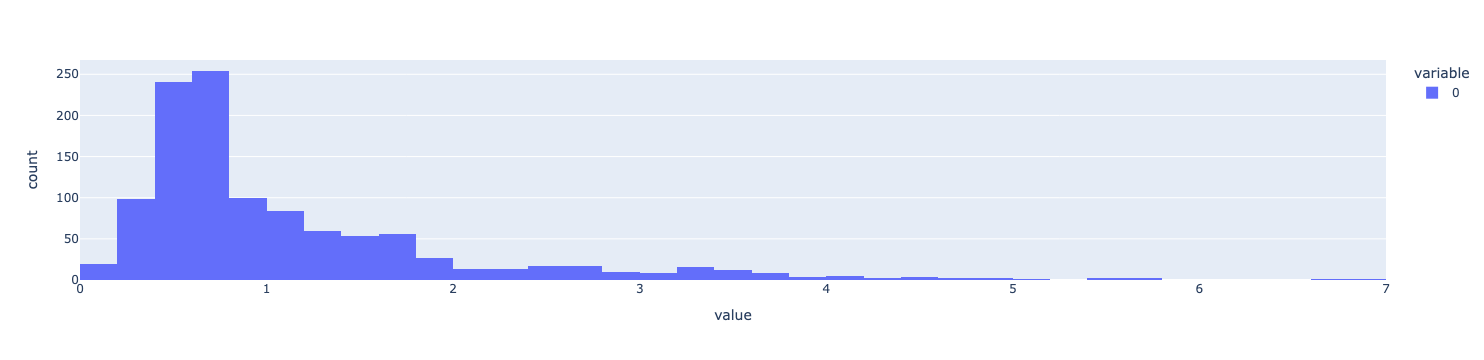

In [78]:
import plotly.express as px

px.histogram(d_m.min(-1))

In [168]:
interface_mask = find_interface(af_model, 'H,L')
all_mask = interface_mask | loop_biasing_mask
af_model._inputs['batch']['all_atom_mask'][-af_model._binder_len:][all_mask, :] = np.zeros_like(af_model._inputs['batch']['all_atom_mask'][-af_model._binder_len:][all_mask, :])

models = af_model._model_names[:2]

flags = {
    "num_recycles": 3,
    "models": models,
    "dropout": True
}

# seq = [target_seq, new_seq]

af_model.predict(seq=new_seq, return_aux=False, verbose=True, seed=2, **flags)
# pdbs = rank_and_write_pdb_predict(af_model, name=os.path.join(output_dir, f"{design_name}.pdb"), write_all=False, renum_pdb=False)